# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 4** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data
Load previously saved dataframe as `.csv` file:

In [3]:
main_dir = r'/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/


Look at what are the different categories in the data.

In [4]:
print(data_df.columns)

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')


# Analysis

Set general general parameters that we will use:

In [5]:
sweep_type = 'active touch'

pre_window = 0.05 # time before whisking onset (s)
post_window = 0.05 # time after whisking onset (s)
min_event_dur = 0 # minimal duration of whisking episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3], 'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP)

Find the free whisking cells and all the unique recorded cells in the data

In [70]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 
data_df_exc = data_df_subset[data_df_subset.Cell_Type=='EXC']
all_cells = np.unique(data_df_exc.Cell_ID)
cell_nb = len(all_cells)
print('Number of cells:', cell_nb)

Number of cells: 67


# Part 4 - correlation between whisker angle and other parameters

Compute what we want and store it in the dictionnary, for each cell

In [71]:
result_dict = {}
for idx, cell_id in enumerate(np.unique(data_df_exc.Cell_ID)):
    cell_df = data_df_exc[data_df_exc.Cell_ID==cell_id]
    #print(cell_df.head(5))
    wp_amp_good = [] # all the amplitudes of whisker protraction for this cell_id, only for selected events
    vm_amp_good = [] # the amplitudes of Vm amplitude for this cell_id, only for selected events
    vm_vel_good = [] # the velocity of Vm for this cell_id, only for selected events
    vm_amp_tot = [] # the amplitudes of Vm amplitude for this cell_id, for all events
    iti_dur_tot = [] # the intertrial durations for this cell_id, for all events
    
    for trial in range(len(cell_df)):
        # initialization
        event_times = cell_df['Sweep_ActiveContactTimes'].values[trial] # active contact times during this trial
        if np.isnan(event_times).any(): # if there is no active contact time during this trial, pass to the next
            continue
        sr_vm = cell_df['Sweep_MembranePotential_SamplingRate'].values[trial] # take the smapling rate of membrane potential
        vm = cell_df['Sweep_MembranePotential'].values[trial] # take the membrane potential
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[trial] #take the derivative of AP threshold
        wp = cell_df['Sweep_WhiskerAngle'].values[trial] # take the whisker angle 
        sr_wp = cell_df['Sweep_WhiskerAngle_SamplingRate'].values[trial] # take the sampling rate of the whisker angle
        wp_time = np.arange(len(wp))/sr_wp # make an array corresponding to the times of each recording of whisker protraction
        vm_time = np.arange(len(vm))/sr_vm # make an array corresponding to the times of each recording of membrane potential

        # detect and cut out APs.
        ap_params = Function_Detect_APs(vm, sr_vm, ap_vm_deriv_thresh)                    
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
                #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(vm, sr_vm, ap_peak_times, ap_thresh_times)
        else:
            vm_sub = vm.copy() # if there is no AP
        l = len(vm_sub)

        # we compute intertrial duration and vm amplitude for touches that are close enough to each other, i.e less than 0.2 seconds apart
        if type(event_times[0]) == np.float64: #there is only one touch in the trial, so we cannot take intertrial duration
            continue

        for event in range(1,len(event_times)):
            start = event_times[event][0]
            end = event_times[event][1]
            if start > end:
                continue
            # Convert the start and end time of the active touch to indices
            start_index_vm = np.searchsorted(vm_time, start)
            end_index_vm = np.searchsorted(vm_time, end+post_window)

            iti_dur = start-event_times[event-1][1]
            if iti_dur < 1:
                iti_dur_tot.append(iti_dur)
                amp_vm = max(vm_sub[start_index_vm:end_index_vm])- min(vm_sub[start_index_vm:end_index_vm])
                vm_amp_tot.append(amp_vm)

        # we compute whisker amplitude, vm amplitude, and vm velocity only for touches that are far enough away from each other
        # we keep only the events that are far away from each other (more than min-iti)
        good_event_times = []
        if type(event_times[0]) == np.float64:
            good_event_times.append(event_times)
        else: 
            for i in range(len(event_times)):
                if i == len(event_times)-1:
                    good_event_times.append(event_times[i])
                elif event_times[i+1][0] - event_times[i][1] > min_iti:
                    good_event_times.append(event_times[i])

        for start, end in good_event_times:
            if start > end:
                continue
            if end >= 20-post_window: # we want to have the complete 0.05 seconds window after the end of the touch
                continue
            # Convert the start and end time of the active touch to indices
            start_index_vm = np.searchsorted(vm_time, start)
            end_index_vm = np.searchsorted(vm_time, end)
            post_index_vm = np.searchsorted(vm_time, end+post_window)
            start_index_wp = np.searchsorted(wp_time, max(start-pre_window,0))
            end_index_wp = np.searchsorted(wp_time, end)
            #print(end_index_vm, post_index_vm)
            #print(len(vm_time))
            
            amp_wp = max(wp[start_index_wp:end_index_wp])- min(wp[start_index_wp:end_index_wp])
            wp_amp_good.append(amp_wp)

            amp_vm = max(vm_sub[start_index_vm:post_index_vm])- min(vm_sub[start_index_vm:post_index_vm])
            vm_amp_good.append(amp_vm)

            if post_index_vm == l:
                post_index_vm = l-1
                time = (l - end_index_vm)/ sr_vm
            else:
                time = post_window
            #print(start_index_vm, end_index_vm,post_index_vm)
            
            vel_vm = (vm_sub[post_index_vm] - vm_sub[end_index_vm]) / time
            vm_vel_good.append(vel_vm)
    #print(cell_id, len(vm_vel_good))
    
    # store all values in the dictionnary, but only if we have more than 10 good events
    if len(vm_vel_good) >= 15:
        result_dict[cell_id] = {}
        result_dict[cell_id]['vm_amplitude'] = vm_amp_tot
        result_dict[cell_id]['vm_amplitude_good'] = vm_amp_good
        result_dict[cell_id]['vm_velocity'] = vm_vel_good
        result_dict[cell_id]['wp_amplitude'] = wp_amp_good
        result_dict[cell_id]['iti_duration'] = iti_dur_tot

/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


In [72]:
len(result_dict)

22

Since we do not want to plot 67 different cells, we randomly choose 4.

In [74]:
import random
good_cells = list(result_dict.keys())
#random_cells = random.sample(sorted(good_cells), 4)
random_cells = ['SC911_1', 'SC912_1', 'SC917_1', 'SC916_1']
print(random_cells)


['SC911_1', 'SC912_1', 'SC917_1', 'SC916_1']


# Plots

We plot the membrane potential amplitude versus the whisker angle amplitude

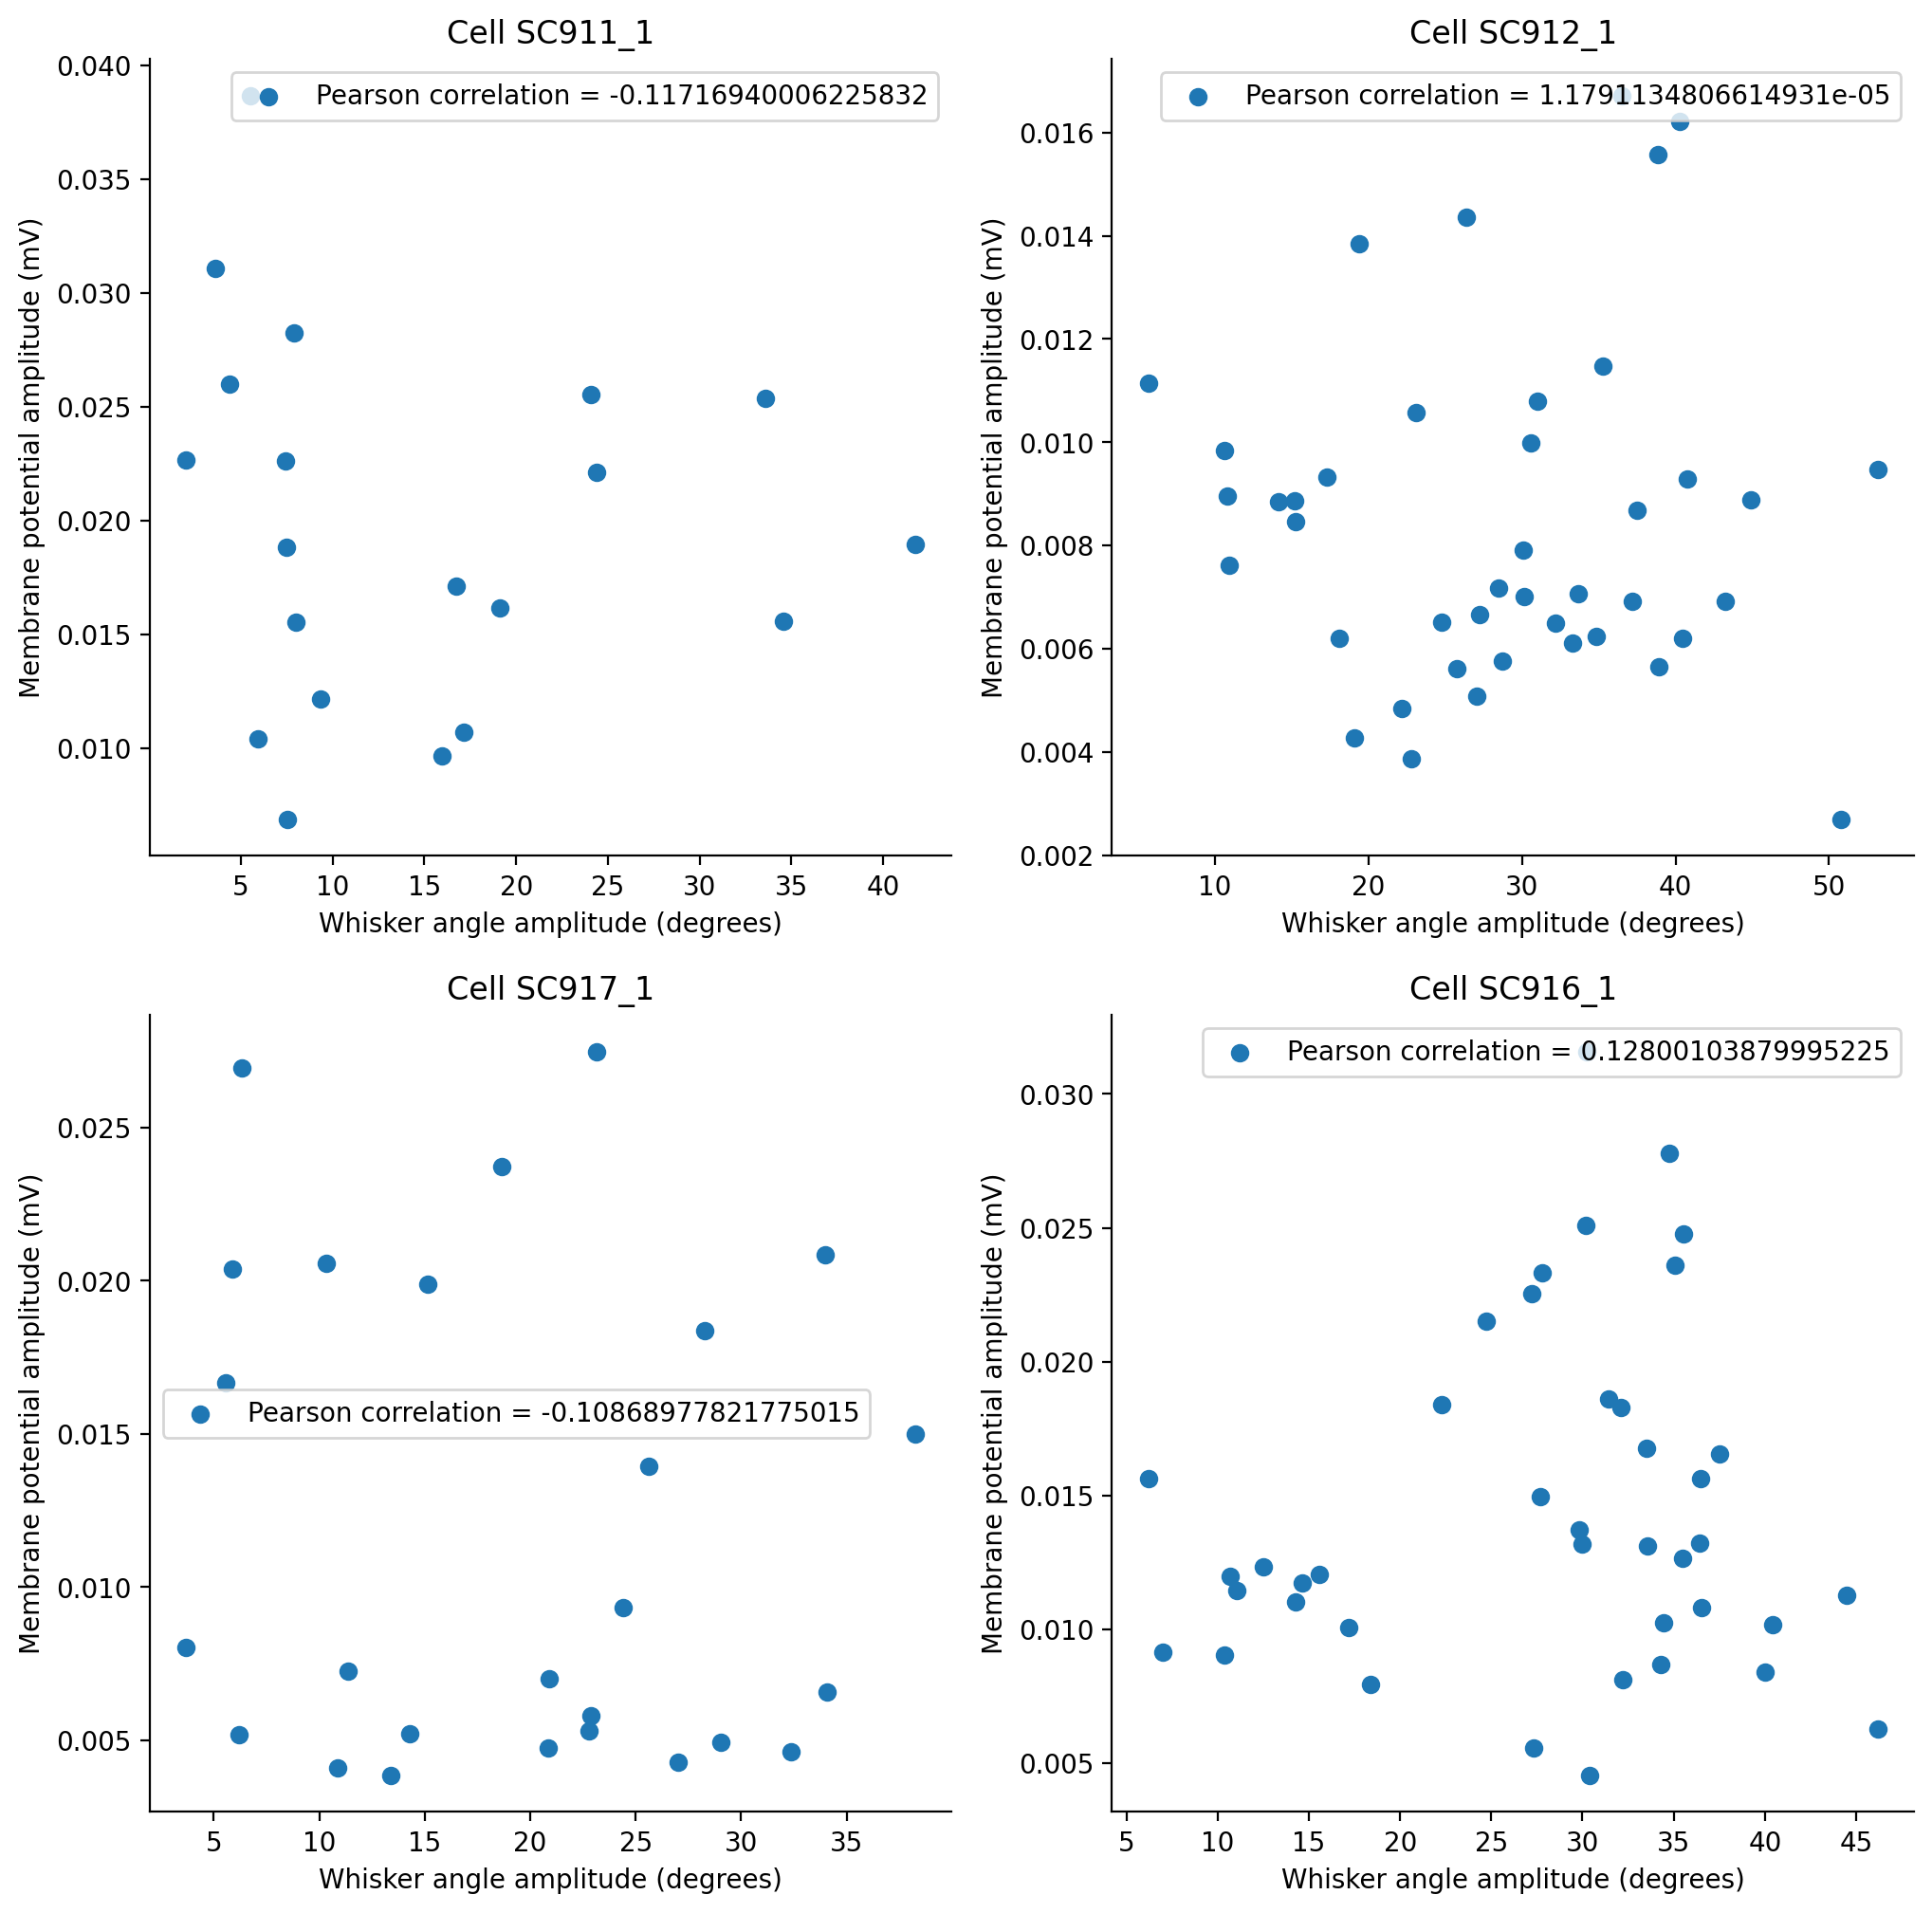

In [80]:
fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=200)

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='Whisker angle amplitude (degrees)', ylabel='Membrane potential amplitude (mV)')

for i in range(4):
    x = int(np.floor(i/2))
    cell = random_cells[i]
    x_values = result_dict[cell]['wp_amplitude']
    y_values = result_dict[cell]['vm_amplitude_good']
    correlation = scipy.stats.pearsonr(x_values, y_values)
    axs[x][i%2].scatter(x_values, y_values, label = f'Pearson correlation = {correlation.statistic}')
    axs[x][i%2].set_title(f'Cell {cell}')
    axs[x][i%2].legend()

We plot the membrane potential velocity versus the whisker angle amplitude

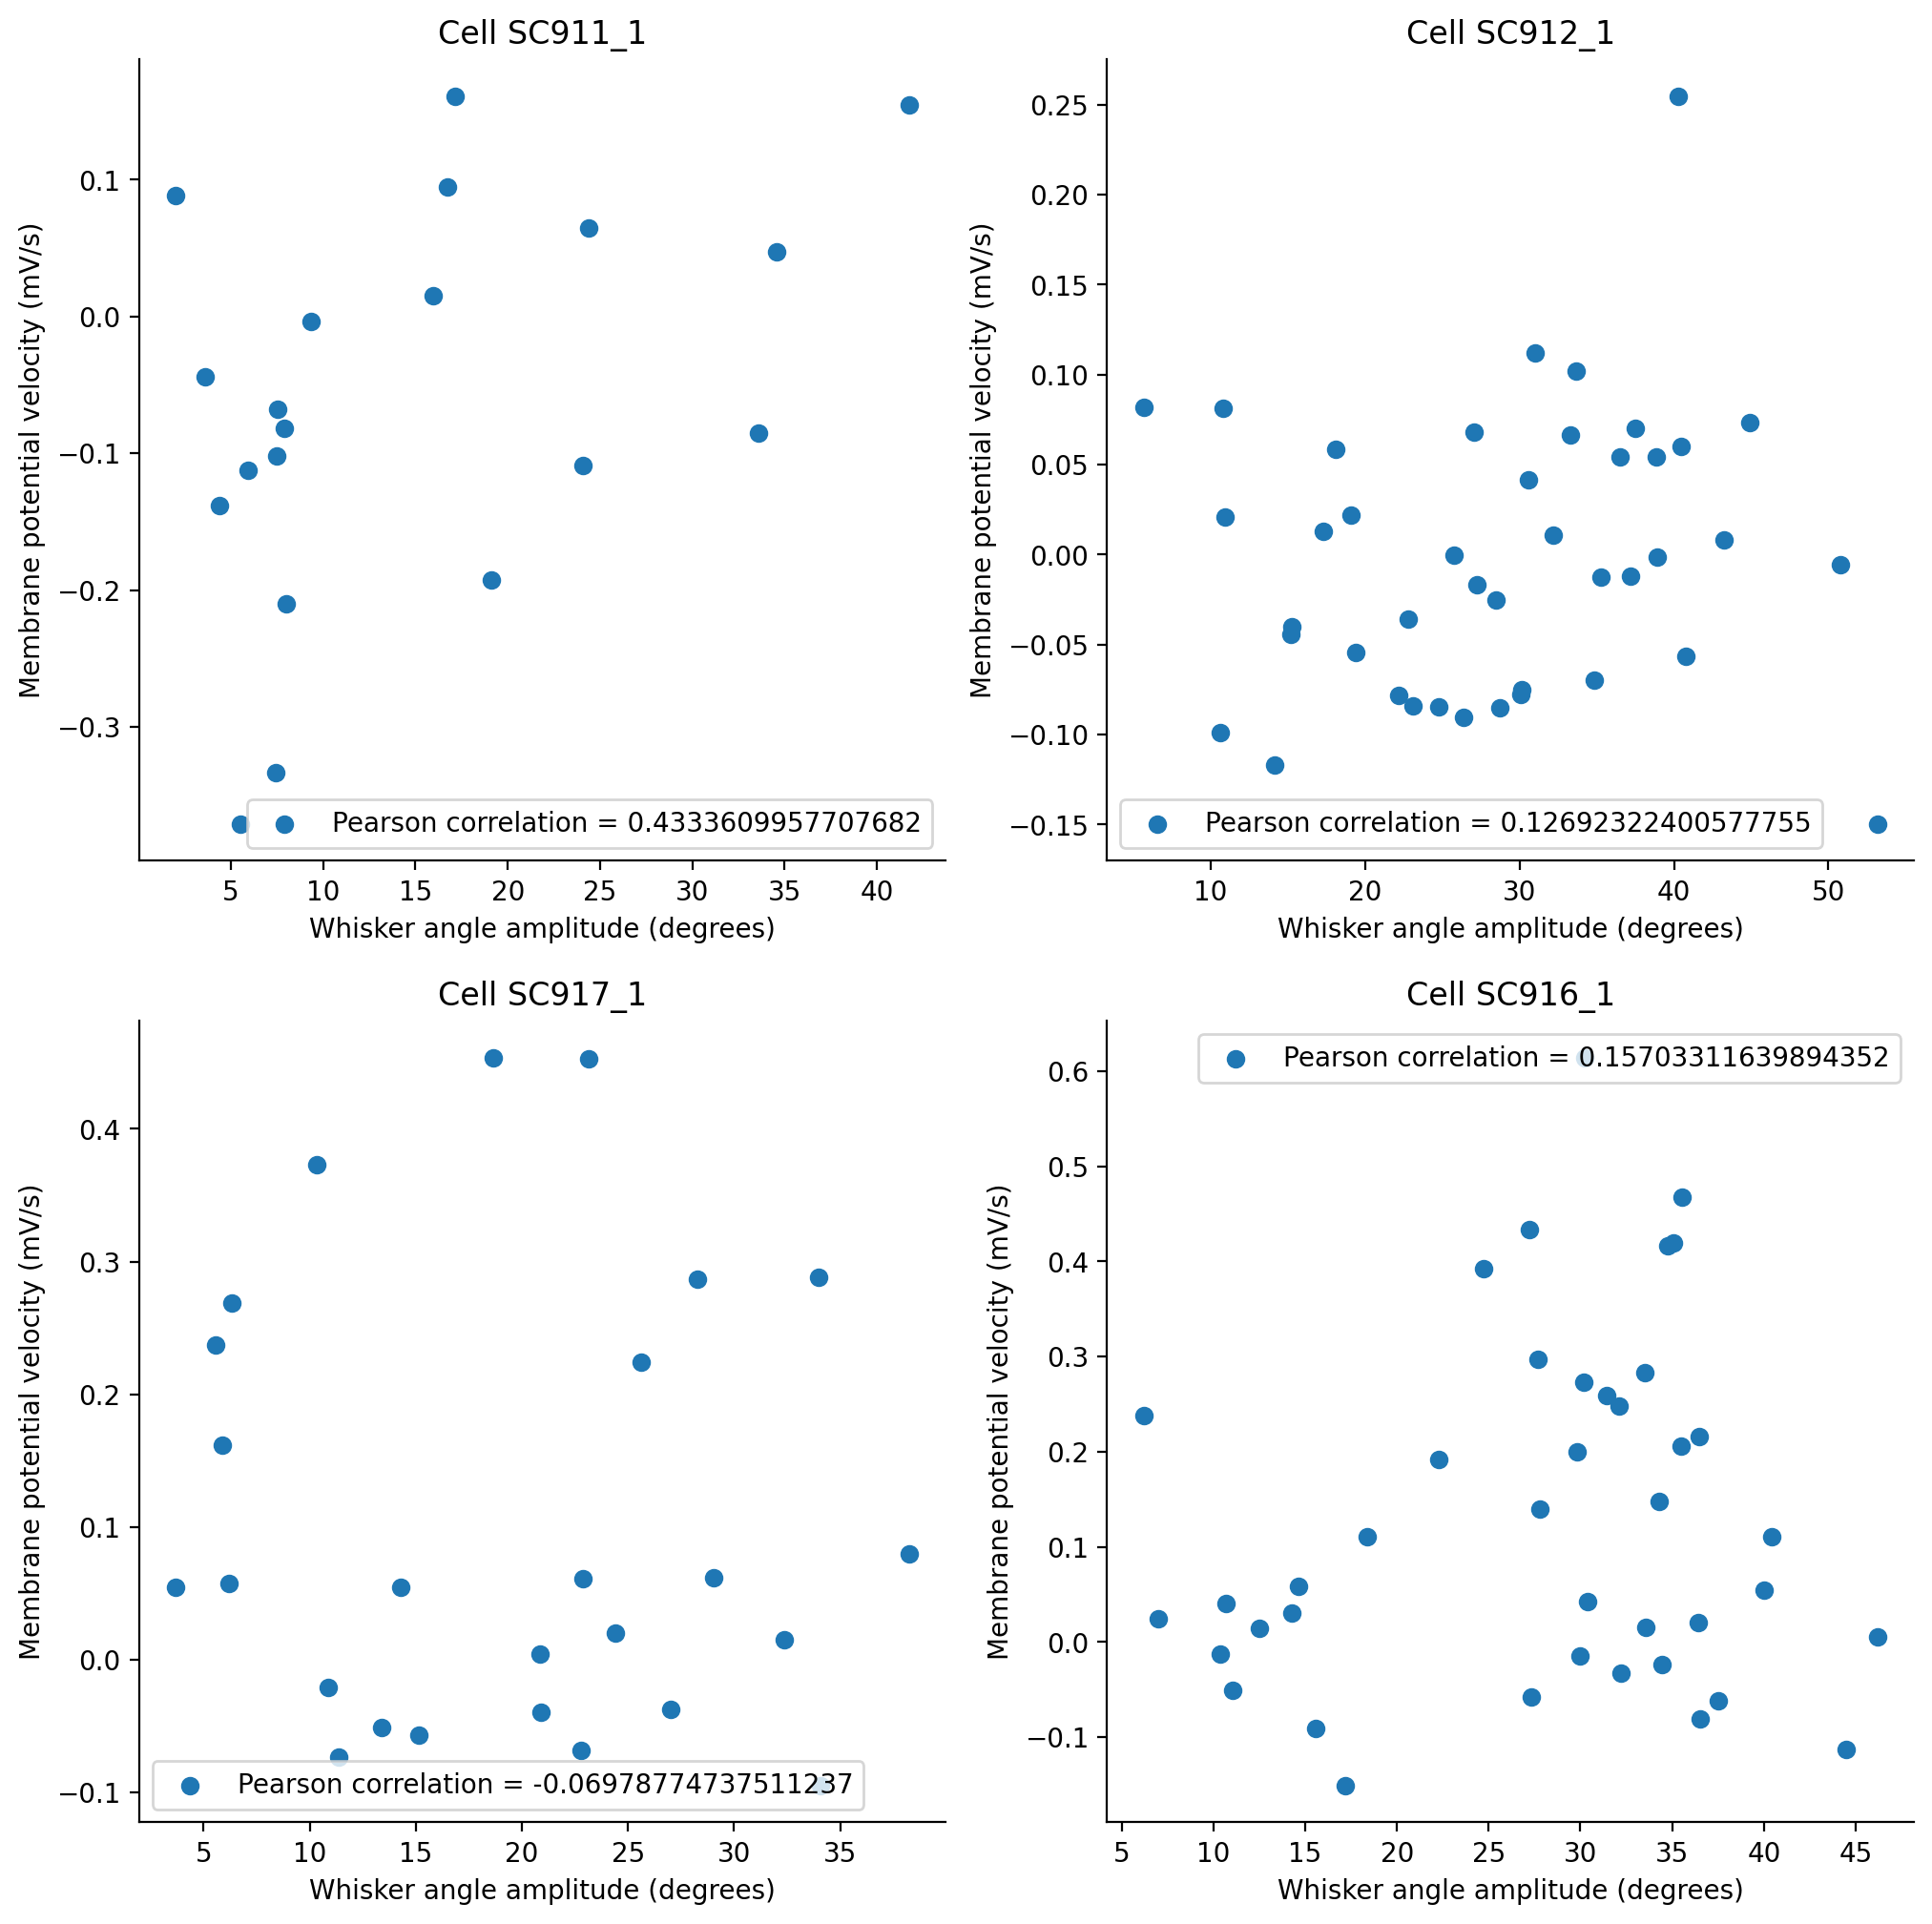

In [81]:
fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=200)

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='Whisker angle amplitude (degrees)', ylabel='Membrane potential velocity (mV/s)')

for i in range(4):
    x = int(np.floor(i/2))
    cell = random_cells[i]
    x_values = result_dict[cell]['wp_amplitude']
    y_values = result_dict[cell]['vm_velocity']
    correlation = scipy.stats.pearsonr(x_values, y_values)
    axs[x][i%2].scatter(x_values, y_values, label = f'Pearson correlation = {correlation.statistic}')
    axs[x][i%2].set_title(f'Cell {cell}')
    axs[x][i%2].legend()


In [65]:
def log_func(x, a, b):
    return a + b * np.log(x)

We plot the intertrial duration vs potential amplitude

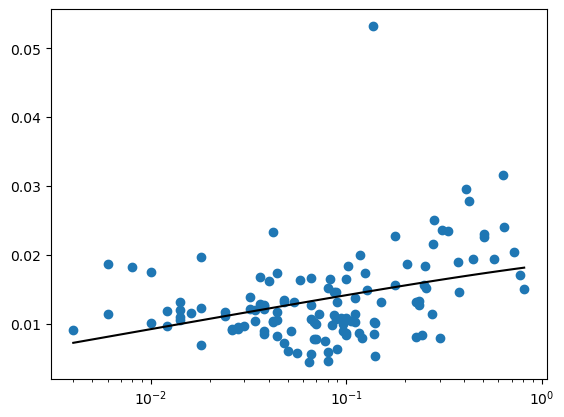

In [86]:
from scipy.optimize import curve_fit
cell = random_cells[3]
x_values = result_dict[cell]['iti_duration']
y_values = result_dict[cell]['vm_amplitude']
popt, pcov = curve_fit(log_func, np.log1p(x_values), y_values)

# Generate points for the fitted curve
x_fit = np.linspace(min(x_values), max(x_values), 100)
y_fit = log_func(np.log1p(x_fit), *popt)

# Scatter plot and fitted curve
plt.scatter(x_values, y_values)
plt.xscale('log')
plt.plot(x_fit, y_fit, color='black')

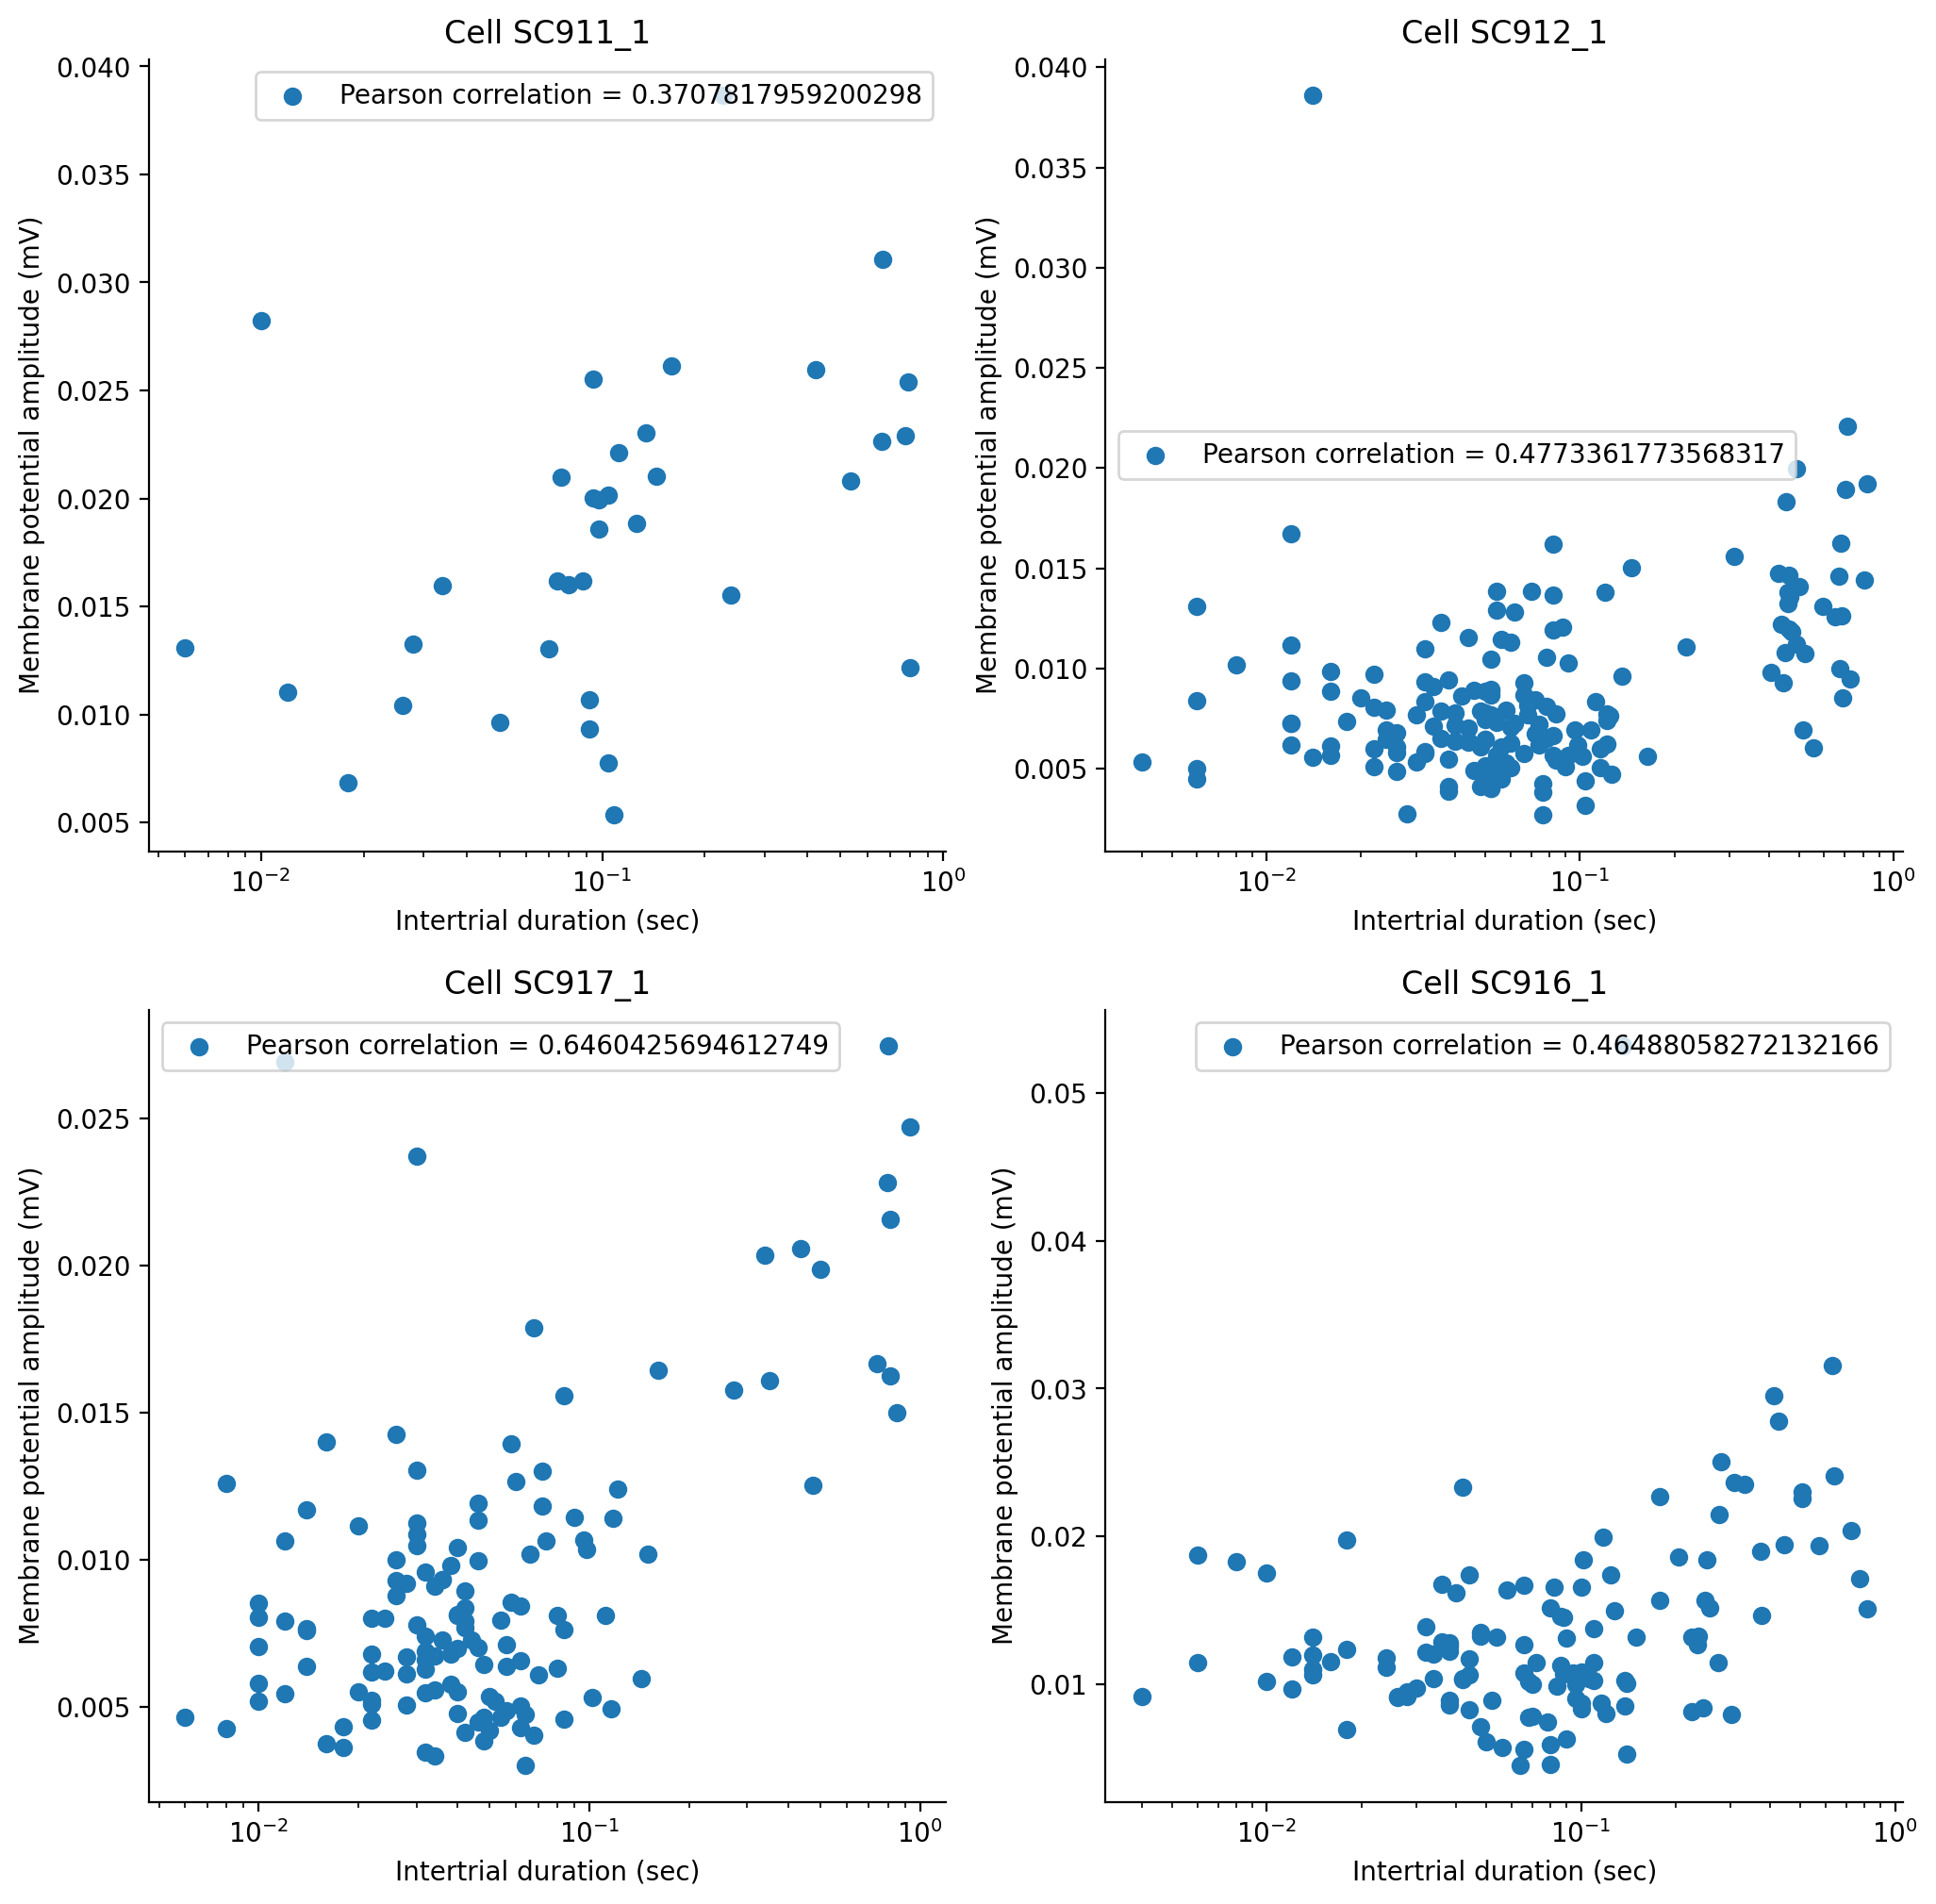

In [83]:
fig, axs = plt.subplots(2,2, figsize=(12,12), dpi=200)

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xscale('log')
    ax.set(xlabel='Intertrial duration (sec)', ylabel='Membrane potential amplitude (mV)')

for i in range(4):
    x = int(np.floor(i/2))
    cell = random_cells[i]
    x_values = result_dict[cell]['iti_duration']
    y_values = result_dict[cell]['vm_amplitude']
    #print(type(x_values))
    correlation = scipy.stats.pearsonr(x_values, y_values)

    axs[x][i%2].scatter(x_values, y_values, label = f'Pearson correlation = {correlation.statistic}')
    axs[x][i%2].set_title(f'Cell {cell}')
    axs[x][i%2].legend()
    #xfit = np.linspace(0,2000,num=200)
    #axs[x][i%2].plot(xfit, logFunc(xfit, *logFit(x_values,y_values)))
    